
# TP2 — Histogram & Contrast Adjustment (Grayscale)

**Auteur :** Loann KAIKA  

In [1]:
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline

base_dir = r"C:/Users/loann/Desktop/cv2/Images" 
files = ["pout.tif", "cameraman.tif", "bureau.gif", "rice.tif", "tire.tif", "circuit.tif", "ic.tif"]


## 1) Lecture, histogramme & profil

On lit une image en niveaux de gris avec OpenCV et on affiche son histogramme.

* L’axe **X** correspond aux niveaux de gris possibles $[0,255]$.
* L’axe **Y** indique le nombre de pixels ayant cette intensité.

L’histogramme décrit donc la **répartition des intensités** :

* concentré vers 0 → image sombre,
* concentré vers 255 → image claire,
* étalé sur toute la plage → image contrastée.

En comparant différentes images (`pout.tif`, `cameraman.tif`, etc.), on observe des histogrammes de formes variées selon leur contenu visuel.


Min = 0 | Max = 255


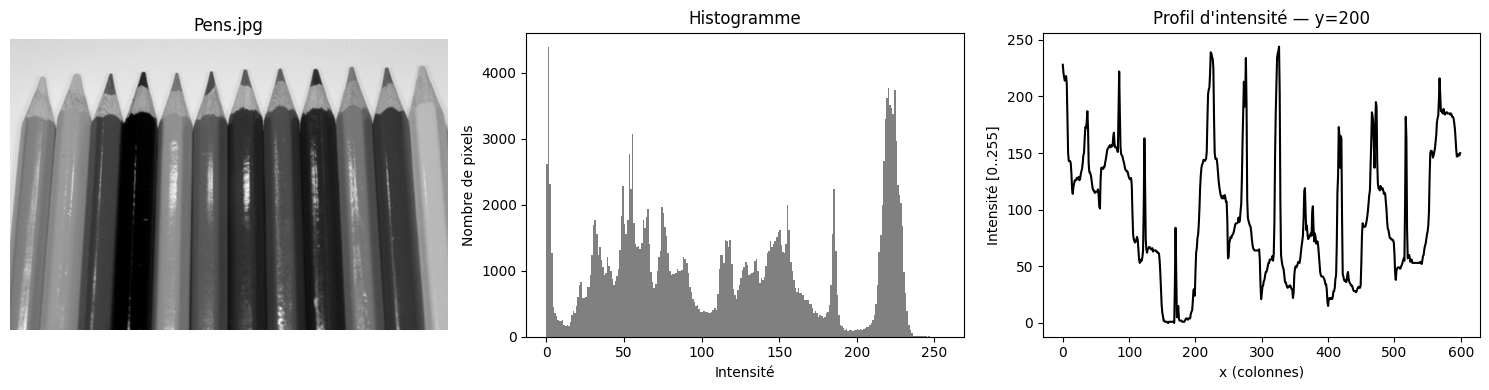

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def load_gray(path: str):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        H, W = 256, 384
        x = np.linspace(0, 1, W, dtype=np.float32)
        grad = np.tile((x*255).astype(np.uint8), (H,1))
        return grad
    return img

def show_all(img, title="Image (grayscale)", y=None, bins=256):
    if y is None: 
        y = img.shape[0] // 2
    
    m, M = int(img.min()), int(img.max())
    print(f"Min = {m} | Max = {M}")

    prof = img[y, :]

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    axes[0].imshow(img, cmap="gray")
    axes[0].set_title(title)
    axes[0].axis("off")

    axes[1].hist(img.ravel(), bins=bins, range=(0,256), color="gray")
    axes[1].set_title("Histogramme")
    axes[1].set_xlabel("Intensité")
    axes[1].set_ylabel("Nombre de pixels")
    
    axes[2].plot(prof, color="black")
    axes[2].set_title(f"Profil d'intensité — y={y}")
    axes[2].set_xlabel("x (colonnes)")
    axes[2].set_ylabel("Intensité [0..255]")

    plt.tight_layout()
    plt.show()

    return prof

base_dir = "C:/Users/loann/Desktop/cv2/Images"
files = ["Pens.jpg"]

img_path = str(Path(base_dir) / files[0])
img = load_gray(img_path)
prof = show_all(img, files[0])



## 2) Normalisation linéaire (min–max)

On calcule les niveaux extrêmes de l’image :

$$
m = \min(I), \quad M = \max(I).
$$

Puis on applique une **transformation affine** qui envoie $m \mapsto 0$ et $M \mapsto 255$ :

$$
I'(x,y) = \frac{I(x,y) - m}{M - m} \cdot 255
$$

* Cette opération **étale l’histogramme** sur toute la plage $[0,255]$
* Le contraste global de l’image est ainsi **renforcé** : les zones sombres deviennent plus noires et les zones claires plus blanches.




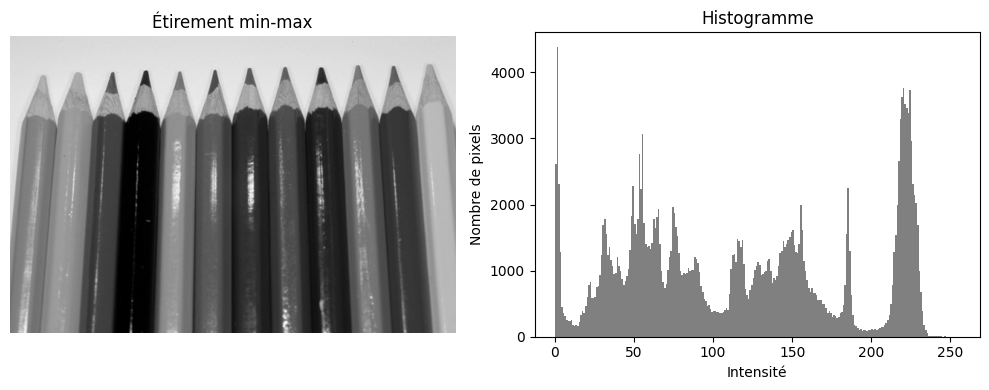

In [4]:
def contrast_stretch(img):
    m, M = img.min(), img.max()
    a = 255.0 / (M - m)
    b = -a * m
    out = a * img.astype(np.float32) + b
    return np.clip(out, 0, 255).astype(np.uint8)

def show_stretch(img, title="Étirement min-max", bins=256):
    out = contrast_stretch(img)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(out, cmap="gray")
    axes[0].set_title(title)
    axes[0].axis("off")
    axes[1].hist(out.ravel(), bins=bins, range=(0,256), color="gray")
    axes[1].set_title("Histogramme")
    axes[1].set_xlabel("Intensité")
    axes[1].set_ylabel("Nombre de pixels")
    plt.tight_layout()
    plt.show()
    return out

out = show_stretch(img)



## 3) Transformation affine

On applique une transformation linéaire de la forme :

$$
I'(x,y) = a \cdot I(x,y) + b,
$$

avec $a$ un **gain** (contraste) et $b$ un **offset** (luminosité).

* Si $a > 1$, le contraste est renforcé ; si $0 < a < 1$, il est réduit.
* Si $b > 0$, l’image est éclaircie ; si $b < 0$, elle est assombrie.
* Les valeurs sont ensuite **clippées** dans $[0,255]$ pour rester valides en 8 bits.

Cette transformation permet de corriger à la fois la **luminosité** et le **contraste** de l’image de manière simple.




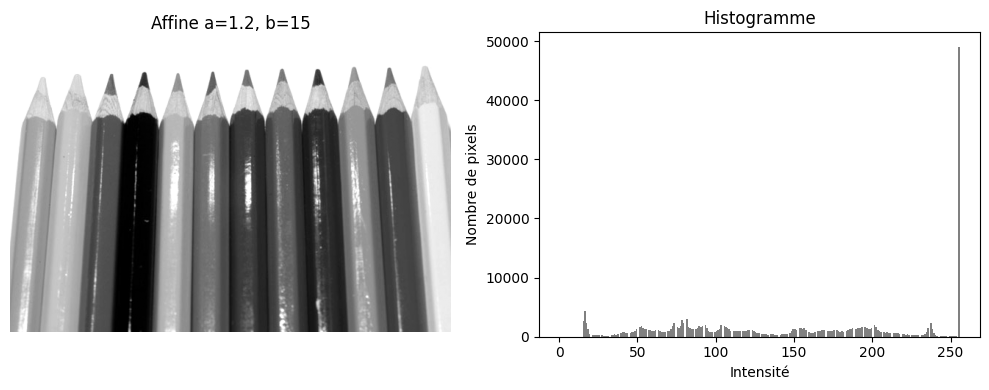

In [7]:
def linear_affine(img, a=1.2, b=15):
    out = a*img.astype(np.float32)+b
    return np.clip(out,0,255).astype(np.uint8)

def show_affine(img, a=1.2, b=15, title="Affine", bins=256):
    out = linear_affine(img, a, b)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(out, cmap="gray")
    axes[0].set_title(f"{title} a={a}, b={b}")
    axes[0].axis("off")
    axes[1].hist(out.ravel(), bins=bins, range=(0,256), color="gray")
    axes[1].set_title("Histogramme")
    axes[1].set_xlabel("Intensité")
    axes[1].set_ylabel("Nombre de pixels")
    plt.tight_layout()
    plt.show()
    return out

out = show_affine(img, a=1.2, b=15)



## 4) Correction gamma

On applique une transformation **non linéaire** sur chaque pixel :

$$
I'(x,y) = 255 \cdot \left(\frac{I(x,y)}{255}\right)^{\gamma}
$$

* Si $\gamma < 1$ → les basses intensités sont augmentées → l’image est **éclaircie** (détails dans les ombres).
* Si $\gamma > 1$ → les basses intensités sont compressées → l’image est **assombrie** (protection des hautes lumières).

La correction gamma modifie donc la **réponse tonale** de l’image sans changer sa dynamique globale, contrairement à l’étirement linéaire.



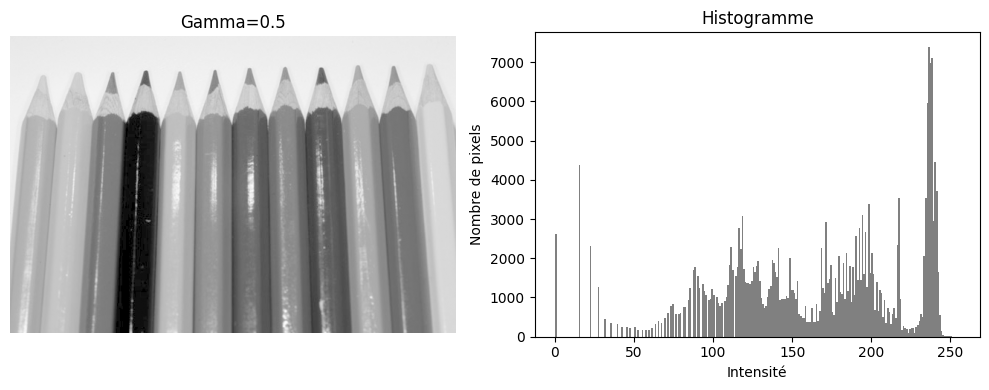

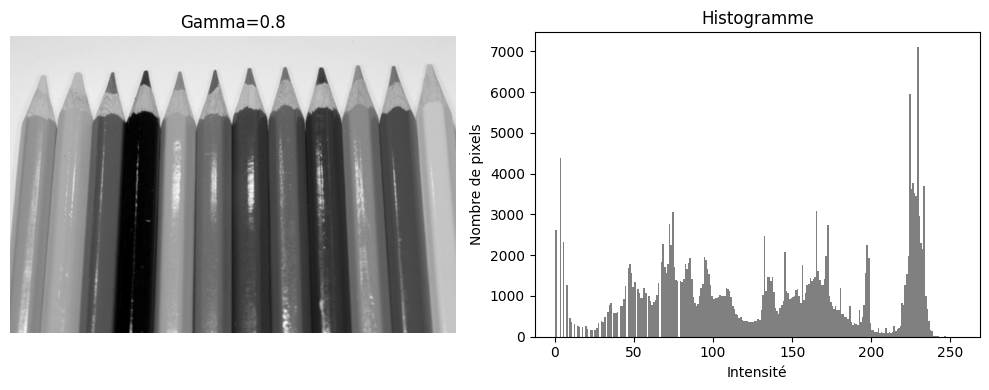

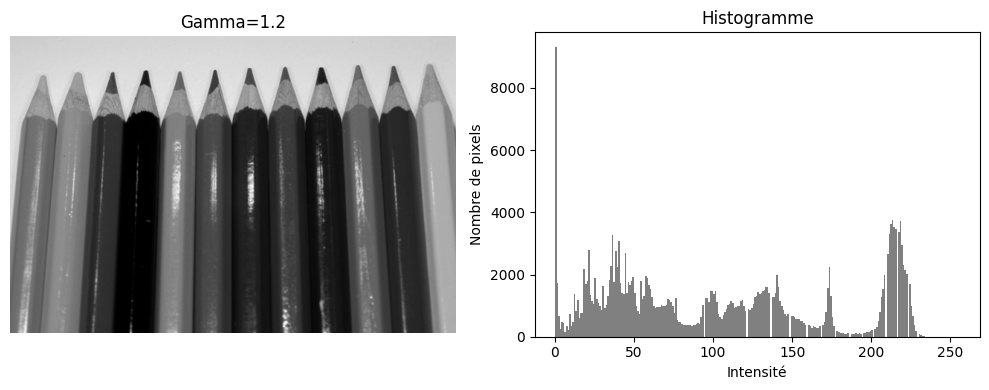

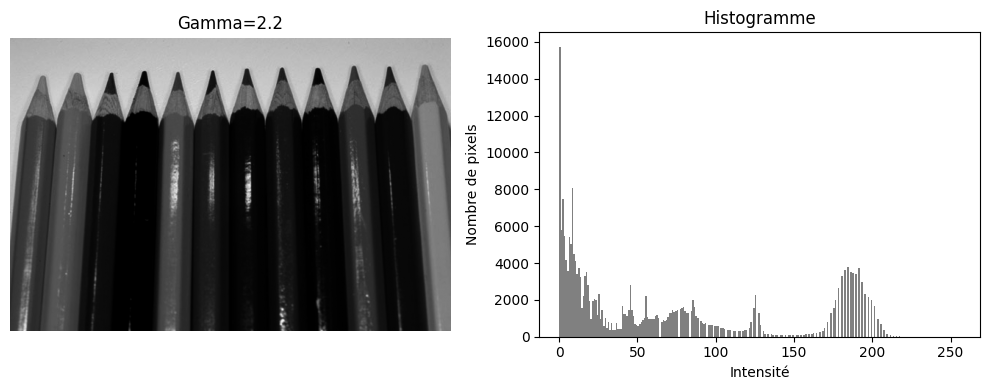

In [8]:
def gamma_correct(img, gamma=0.6):
    x = img.astype(np.float32)/255.0
    y = np.power(x, gamma)
    return np.clip(y*255,0,255).astype(np.uint8)

def show_gamma(img, gamma=0.6, bins=256):
    out = gamma_correct(img, gamma)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(out, cmap="gray")
    axes[0].set_title(f"Gamma={gamma}")
    axes[0].axis("off")
    axes[1].hist(out.ravel(), bins=bins, range=(0,256), color="gray")
    axes[1].set_title("Histogramme")
    axes[1].set_xlabel("Intensité")
    axes[1].set_ylabel("Nombre de pixels")
    plt.tight_layout()
    plt.show()
    return out

for g in [0.5, 0.8, 1.2, 2.2]:
    out = show_gamma(img, g)



## 5) Égalisation d'histogramme

L’égalisation vise à redistribuer les intensités pour obtenir un histogramme plus uniforme.

* **Égalisation globale (`cv2.equalizeHist`)** :
  On applique la fonction de répartition cumulative (CDF) de l’histogramme comme transformation.

  $$
  I'(x,y) = \text{round}\!\left(255 \cdot \frac{\text{CDF}(I(x,y))}{\text{CDF}(255)}\right)
  $$

  Le contraste est amélioré surtout dans les zones ternes, mais du bruit peut apparaître.

* **Égalisation locale (CLAHE)** :
  L’image est découpée en tuiles, chacune est égalisée puis recollée avec une limitation du contraste (*clip limit*).
  Permet de renforcer le contraste **localement** tout en évitant l’amplification du bruit.



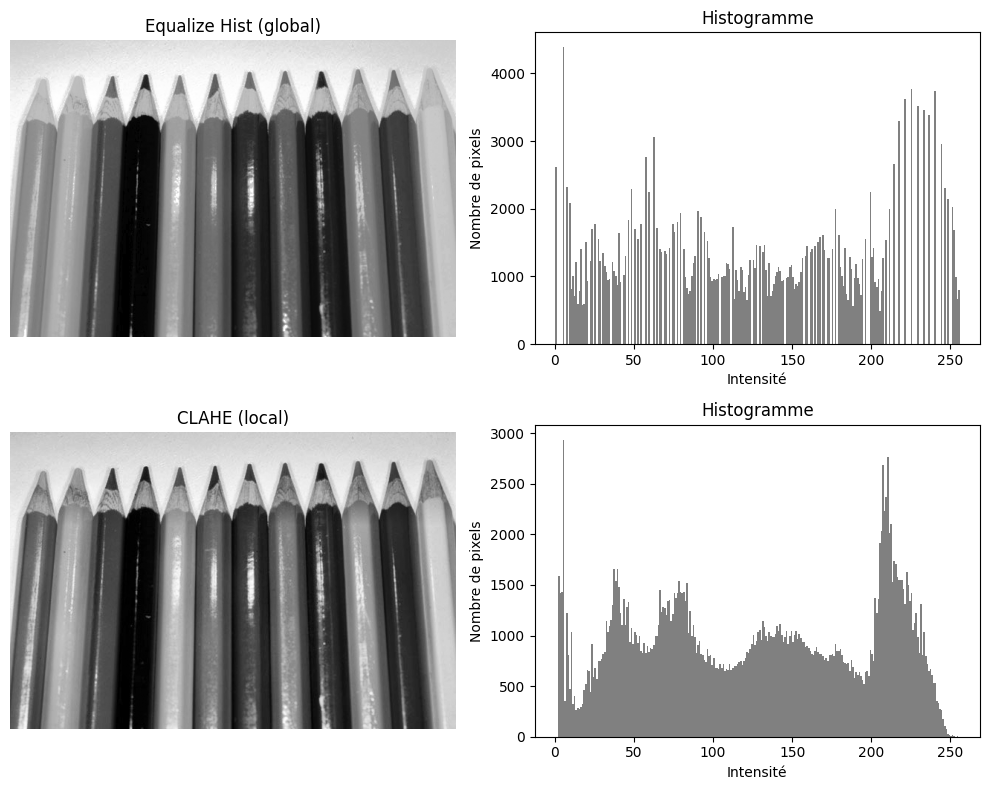

In [9]:
eq = cv2.equalizeHist(img)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl = clahe.apply(img)

def show_compare(imgs, titles, bins=256):
    fig, axes = plt.subplots(len(imgs), 2, figsize=(10, 4*len(imgs)))
    if len(imgs) == 1:
        axes = [axes]
    for i, (im, t) in enumerate(zip(imgs, titles)):
        axes[i][0].imshow(im, cmap="gray")
        axes[i][0].set_title(t)
        axes[i][0].axis("off")
        axes[i][1].hist(im.ravel(), bins=bins, range=(0,256), color="gray")
        axes[i][1].set_title("Histogramme")
        axes[i][1].set_xlabel("Intensité")
        axes[i][1].set_ylabel("Nombre de pixels")
    plt.tight_layout()
    plt.show()

show_compare([eq, cl], ["Equalize Hist (global)", "CLAHE (local)"])
